<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e5?scriptVersionId=174979746" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://d39eazhratf38c.cloudfront.net/Pictures/480xany/2/9/2/60292_142839_996015.jpg)

# <span style="color: #44944A">I really sympathize with the people who had to go through the flood. I hope the governments of such countries will do everything possible to help people restore their property and life stability!

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv
/kaggle/input/flood-prediction-factors/flood.csv


## *Your Goal*: The goal of this competition is to predict the probability of a region flooding based on various factors.

<font face="Bahnschrift Condensed" style="font-size: 14pt; color: brown">
Flood detection refers to the process of identifying, monitoring, and alerting authorities or individuals about the presence or likelihood of flooding in a particular area. It involves the use of various technologies and methods to detect, predict, and mitigate the impacts of floods.
</font>

![](https://www.kaggle.com/competitions/73278/images/header)

# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 50px;">Table of Contents</span>

- [Import libraries](#1)
- [Open data files](#2)
- [Show first 5 lines of train data](#3)
- [Compare original train and competition train](#3.1)
- [Concatenate original train with competition train](#3.2)
- [Figure out how much duplicates in data](#3.3)
- [Shapes of train and test data](#4)
- [Display descriptive statistics of train data](#5)
- [Check the number of gaps for each feature](#6)
- [One-hot encoding](#7.3)
- [Display histograms of distribution](#8)
- [Let's count target of train data](#9)
- [Transform the data with log1p](#10)
- [Feature importance](#10.2)
- [Build a heat map of correlations](#11)
- [Define base models with tuned hyperparameters](#12)
- [Defining the meta-model with tuned hyperparameters](#13)
- [Creating and fitting the stacking model](#14)
- [Predict validation set and calculate metrics score](#15)
- [Predict the test data](#16)
- [Build DataFrame and make submission](#17)
- [Save the model into pickle file](#18)

<a id='1'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 Import libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

![](https://s.france24.com/media/display/f441dde2-f637-11ed-aeef-005056bf30b7/w:980/p:16x9/000_33FG2YF.jpg)

<a id='2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

<a id='3'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [5]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


## <span style="color: #A8E4A0">Target feature is **FloodProbability**

<a id='3.1'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Compare original train and competition train</span>

In [6]:
print(original_train.shape)
original_train.columns.tolist()

(50000, 21)


['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

## <span style="color: #A8E4A0">In original data there is no **id** column

In [7]:
print(train.shape)
train.columns.tolist()

(1117957, 22)


['id',
 'MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

<a id='3.2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚣 Concatenate original train with competition train

In [8]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

In [9]:
train = pd.concat(objs=[train, original_train])
train.shape

(1167957, 21)

<a id='3.3'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🛟 Figure out how much duplicates in data

In [10]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

0
0


<a id='4'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0">🚨 Shapes of train and test data</span>

In [11]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100:.2f}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100:.2f}% of all observations')

Train data: (1167957, 21)
Test data: (745305, 20)

Train data consists of 61.05% of all observations
Test data consists of 38.95% of all observations


![](https://akm-img-a-in.tosshub.com/lingo/itne/images/story/202208/new_project_18-sixteen_nine.jpg?size=948:533)

<a id='5'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚧 Display descriptive statistics of train data</span>

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1167957.0,4.924448,2.064482,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1167957.0,4.929129,2.100671,0.000,3.00,5.000,6.00,18.000
RiverManagement,1167957.0,4.957917,2.079283,0.000,4.00,5.000,6.00,16.000
Deforestation,1167957.0,4.945076,2.059346,0.000,4.00,5.000,6.00,17.000
Urbanization,1167957.0,4.944509,2.090501,0.000,3.00,5.000,6.00,17.000
ClimateChange,1167957.0,4.936415,2.065289,0.000,3.00,5.000,6.00,17.000
DamsQuality,1167957.0,4.958424,2.090286,0.000,4.00,5.000,6.00,16.000
Siltation,1167957.0,4.930394,2.073436,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1167957.0,4.945338,2.075964,0.000,3.00,5.000,6.00,16.000
Encroachments,1167957.0,4.951676,2.090378,0.000,4.00,5.000,6.00,18.000


<a id='6'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🏥 Check the number of gaps for each feature</span>

In [13]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64



TEST data

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0

## <span style="color: #A8E4A0">There is no any gaps in the data

![](https://img.theweek.in/content/dam/week/week/news/world/images/2024/4/6/Russia-floods-reuters.jpg)

<a id='7'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌧️ Data types of training set</span>

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167957 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null  int64 

<a id="7.3"></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 One-hot encoding

In [15]:
X = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

<a id='8'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Display histograms of distribution</span>

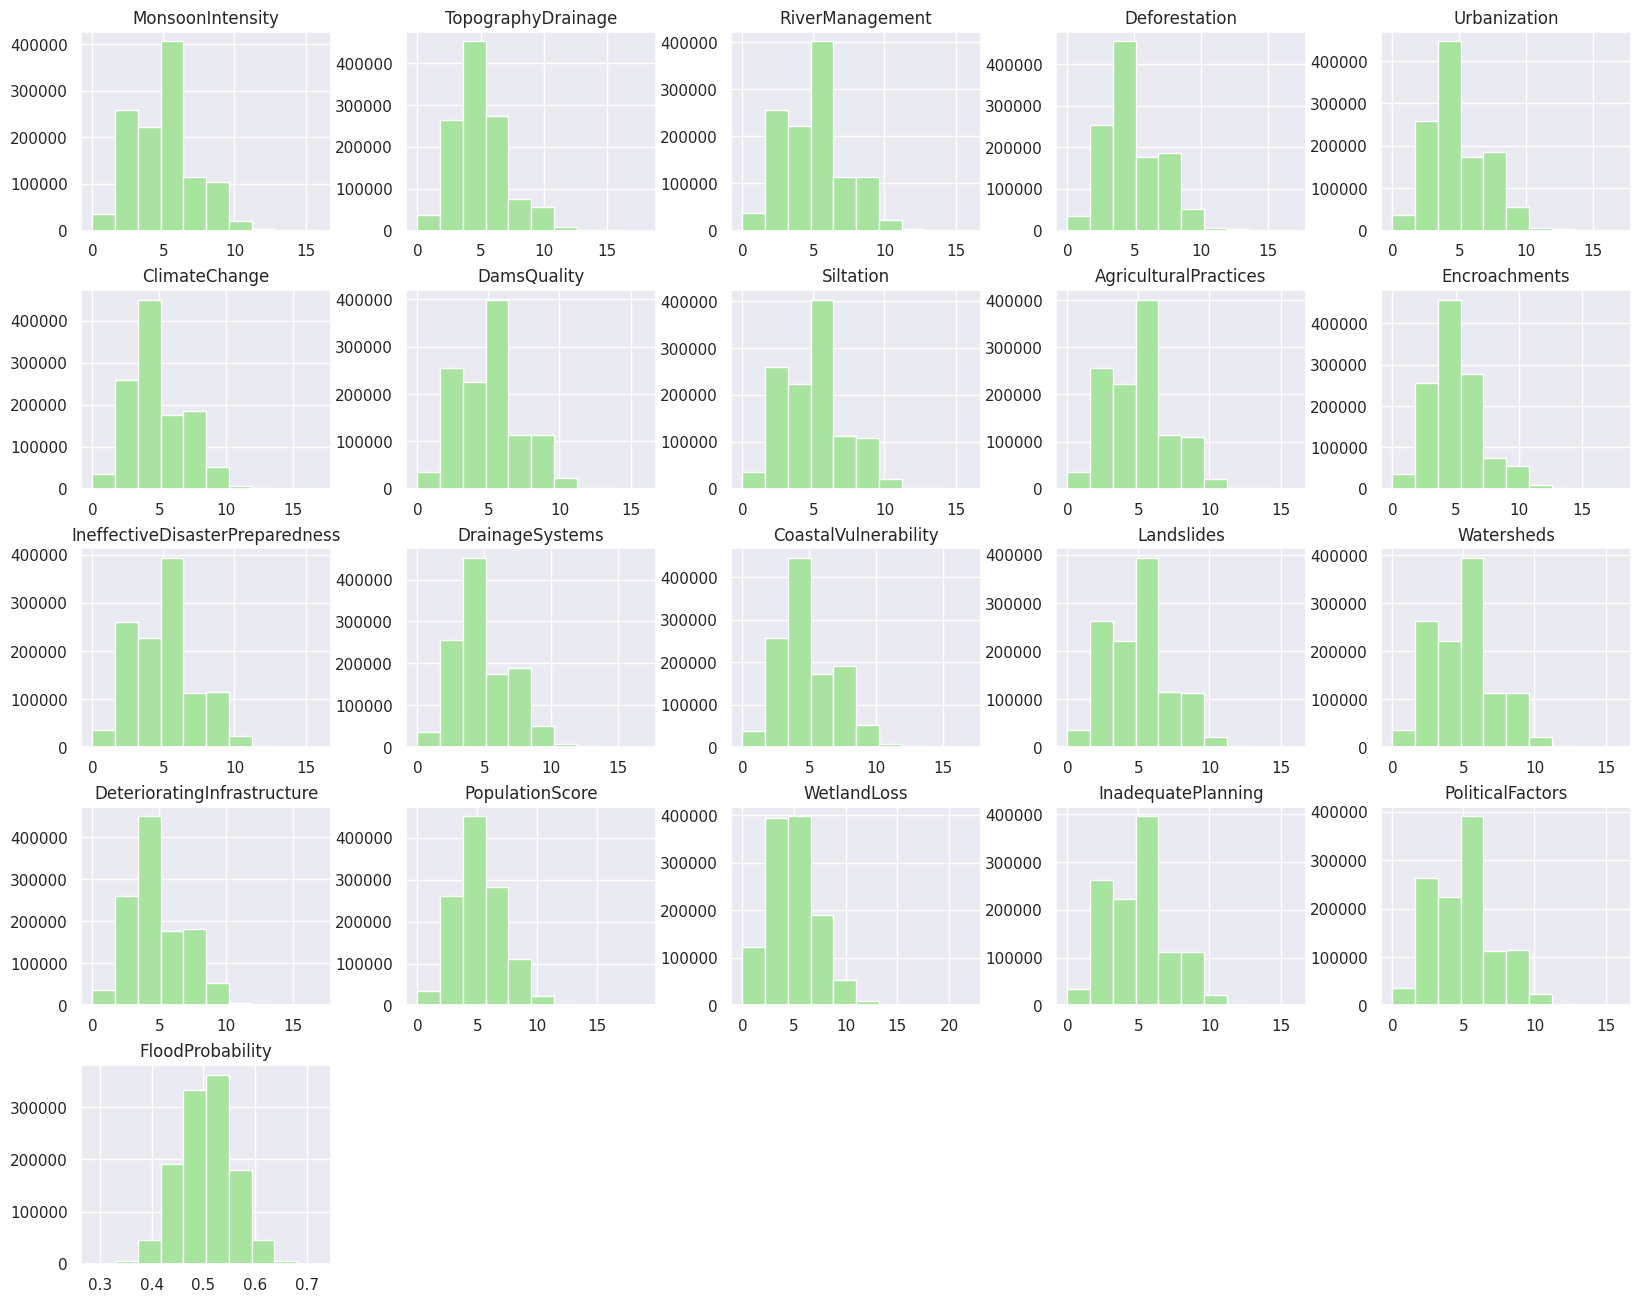

In [16]:
sns.set(rc={'figure.figsize': (20, 16)})
X.hist(color='#A8E4A0');

In [17]:
# Split the train data into X and y
X = X.drop(['FloodProbability'], axis=1)
y = train.FloodProbability